In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from scipy.signal import find_peaks
from typing import List

# plt.style.use("bmh")
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.grid'] = True
# plt.rcParams.keys()

In [18]:
def cargar_datos(file_name : str, pow_measure = False) -> List[np.ndarray]:
    
    # Cargamos los datos
    with open(file_name, "rb") as f:
        dic = pickle.load(f)
    # Hago una lista con los valores de offset que alimentamos con el generador de funciones
    offs_values_keys = list(dic.keys())
    # Valores de corriente en mA
    corr_values = np.array([np.mean(dic[offset]["V_1"])*1000 for offset in offs_values_keys])
    # Varianza de la corriente
    corr_err_values = np.array([np.std(dic[offset]["V_1"])*1000 for offset in offs_values_keys])
    # Verdaderos valores de continua
    offs_true_values = np.array([np.mean(dic[offset]["V_2"]) for offset in offs_values_keys])
    # Le sacamos la "V" a las keys
    offs_values = np.array([float(offset[:-1]) for offset in offs_values_keys])

    # Creamos una lista para guardar todos los datos que nos interesan
    lista_mediciones = [offs_values, offs_true_values, corr_values, corr_err_values]

    # Mediciones de la potencia
    if pow_measure:
        POW_values = [np.mean(dic[offset]["POW"])*1000 for offset in offs_values_keys] # Potencia en mW
        POW_var_values = [np.std(dic[offset]["POW"])*1000 for offset in offs_values_keys] # Potencia en mW

        lista_mediciones.append(POW_values)
        lista_mediciones.append(POW_var_values)

    return lista_mediciones

# Fotodetectores continua

In [105]:
file_name = '../mediciones/D.D/Fotodetectores/Fotodetector A - Barrido offset.pickle'

dic = pickle.load(open(file_name, "rb"))

In [106]:
corr, V_fotodetector = [], []
for key in dic.keys():
    corr.append(np.mean(dic[key]["V_1"]))
    V_fotodetector.append(np.mean(dic[key]["V_2"]))

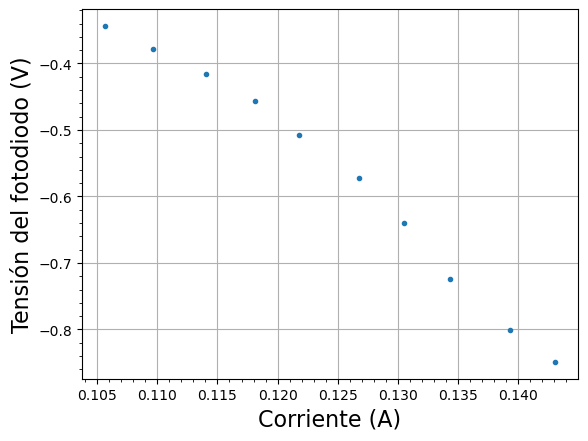

In [107]:
plt.plot(np.abs(corr),V_fotodetector,".")
plt.xlabel("Corriente (A)")
plt.ylabel("Tensión del fotodiodo (V)")
plt.show()

# Medición de linealidad de la resta girando un polarizador


Escala canal 1 = 50 mV

Escala canal 2 = 100 mV

Escala temporal = 25 ms

Ángulo lámina de onda = 282° ± 2°

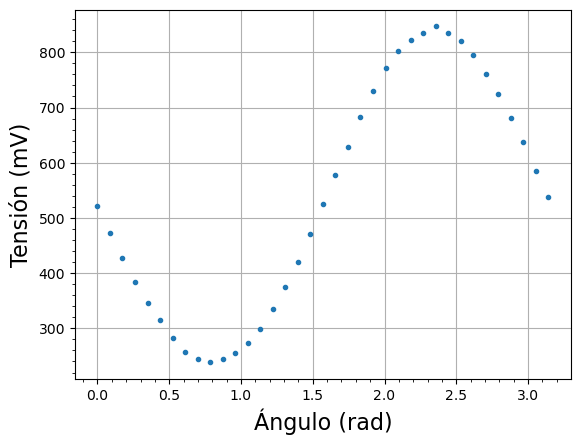

In [108]:
corriente_laser = 125.9 # mA

angulo_polarizador = np.radians([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,
                                 95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180]) # Angulo asado a radianes 

tension_resta = [521.7, 473.1, 428.2,384.7,346.8,314.3,282.6,257.5,244.5,238.3,244.6,254.6,
                 273.5,298.6,335.2,375.3,420.2,471.2,524.4,578.5,627.9,683.2,729.1,771.2,802.3,
                 823.2,834.3,846.9,835.3,821.4,795.4,761.2,723.7,681.3,636.8,585.7,537.3] # mV

plt.plot(angulo_polarizador, tension_resta, ".")
plt.xlabel("Ángulo (rad)")
plt.ylabel("Tensión (mV)")
plt.show()

In [109]:
def func(x, I0,phi,offset):
    return I0*np.sin(2*x+phi)+offset

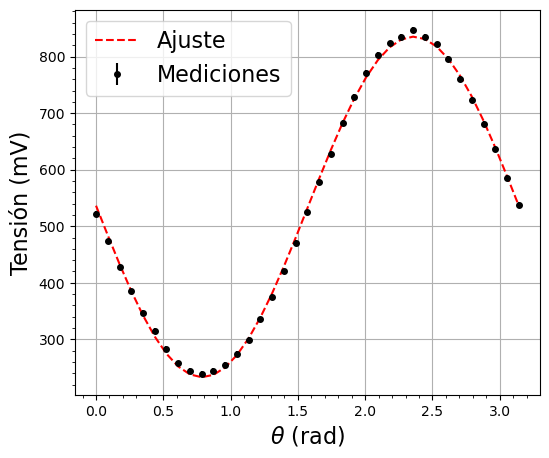

In [110]:
popt, pcov = curve_fit(func, angulo_polarizador, tension_resta)

fig, ax = plt.subplots(ncols = 1, figsize = (6,5))
ax.plot(angulo_polarizador, func(angulo_polarizador,*popt), label = "Ajuste", ls = "--", c = "r")
ax.errorbar(angulo_polarizador, tension_resta, yerr = 5*np.ones(len(angulo_polarizador)), fmt = ".k", ms = 8, label = "Mediciones")
ax.set_xlabel(r"$\theta$"+ " (rad)")
ax.set_ylabel("Tensión (mV)")
ax.legend()
plt.show()

In [111]:
popt

array([301.12341682,  65.96612552, 534.10258744])

In [112]:
def lineal(x,a,b):
    return a*x+b

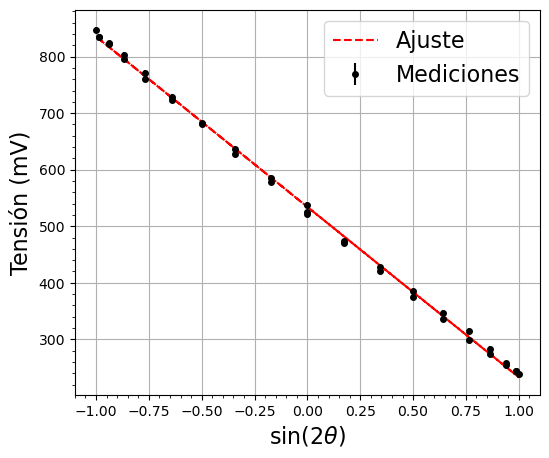

In [113]:
seno = np.sin(2*angulo_polarizador)

popt, pcov = curve_fit(lineal, seno, tension_resta)

fig, ax = plt.subplots(ncols = 1, figsize = (6,5))
ax.plot(seno, lineal(seno,*popt), label = "Ajuste", ls = "--", c = "r")
ax.errorbar(seno, tension_resta, yerr = 5*np.ones(len(angulo_polarizador)), fmt = ".k", ms = 8, label = "Mediciones")
ax.set_xlabel(r"$\sin(2\theta)$")
ax.set_ylabel("Tensión (mV)")
ax.legend()
plt.show()

In [114]:
print(popt)

[-301.11534894  534.16216216]


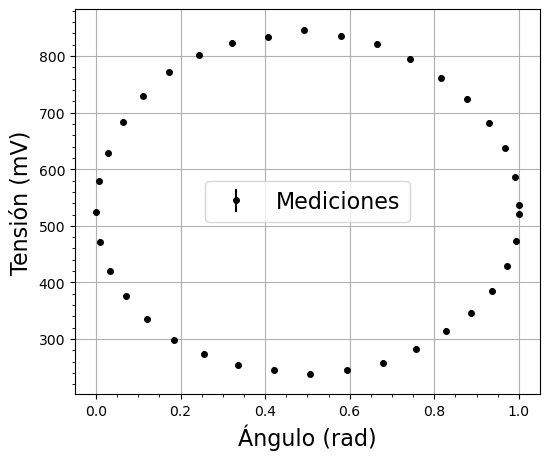

In [115]:
coseno = np.cos(angulo_polarizador+65.96612552)**2

fig, ax = plt.subplots(ncols = 1, figsize = (6,5))
ax.errorbar(coseno, tension_resta, yerr = 5*np.ones(len(angulo_polarizador)), fmt = ".k", ms = 8, label = "Mediciones")
ax.set_xlabel("Ángulo (rad)")
ax.set_ylabel("Tensión (mV)")
ax.legend()
plt.show()

# Responsividad fotodetectores

Escalas de los canales del osciloscopio: ambas en 50 mV

In [34]:
file_name = '../mediciones/D.D/Fotodiodos/Fotodiodo A - Barrido continua - R50.pickle'

offs_values, V_fotodiodo_A, corr_values_A, corr_est_err = cargar_datos(file_name, pow_measure = False)

file_name = '../mediciones/D.D/Fotodiodos/Fotodiodo B - Barrido continua - R50.pickle'

offs_values, V_fotodiodo_B, corr_values_B, corr_est_err = cargar_datos(file_name, pow_measure = False)

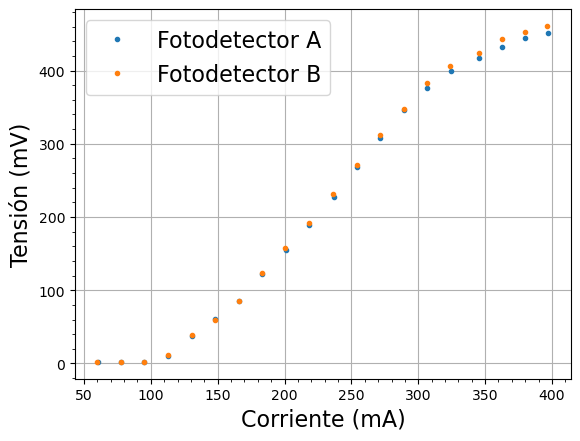

In [40]:
plt.plot(-corr_values_A, 1000*V_fotodiodo_A,".", label = "Fotodetector A")
plt.plot(-corr_values_B, 1000*V_fotodiodo_B,".", label = "Fotodetector B")

plt.xlabel("Corriente (mA)")
plt.ylabel("Tensión (mV)")

plt.legend()
plt.show()

Barrido fino

In [43]:
file_name = '../mediciones/D.D/Fotodiodos/Fotodiodo A - Barrido continua - R50 - fino.pickle'

offs_values, V_fotodiodo_A, corr_values_A, corr_est_err = cargar_datos(file_name, pow_measure = False)

file_name = '../mediciones/D.D/Fotodiodos/Fotodiodo B - Barrido continua - R50 - fino.pickle'

offs_values, V_fotodiodo_B, corr_values_B, corr_est_err = cargar_datos(file_name, pow_measure = False)


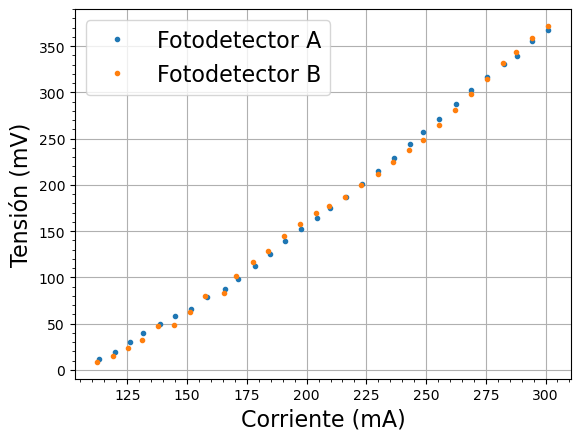

In [44]:
plt.plot(-corr_values_A, 1000*V_fotodiodo_A,".", label = "Fotodetector A")
plt.plot(-corr_values_B, 1000*V_fotodiodo_B,".", label = "Fotodetector B")

plt.xlabel("Corriente (mA)")
plt.ylabel("Tensión (mV)")

plt.legend()
plt.show()

# Analisis en función de la potencia del láser

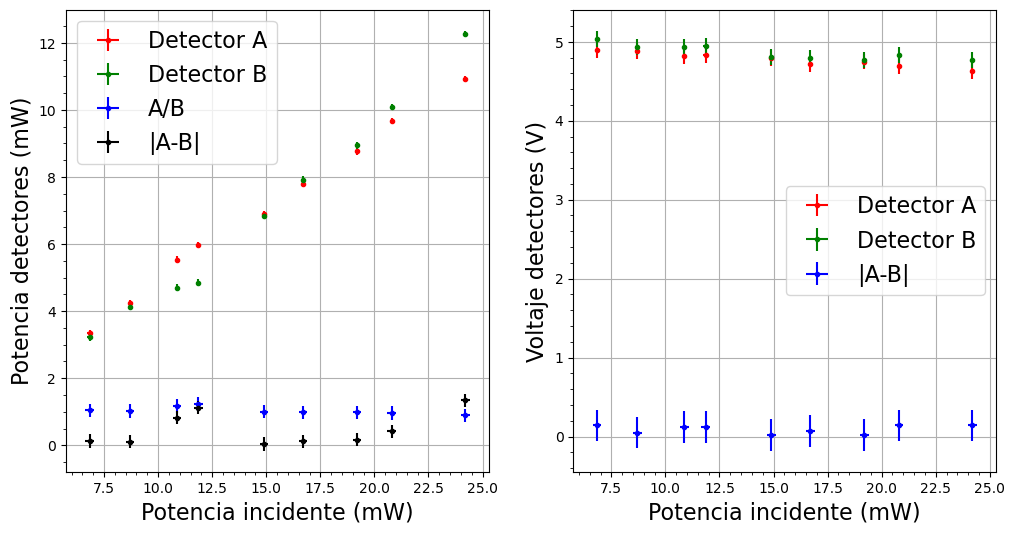

In [21]:
potencia_total = np.array([14.9, 16.7, 19.2, 20.8, 24.2, 11.86, 10.88, 8.7, 6.83])
potencia_A = np.array([6.89, 7.8, 8.77, 9.67, 10.92, 5.97, 5.53, 4.24, 3.35])
potencia_B = np.array([6.85, 7.92, 8.94, 10.09, 12.26, 4.85, 4.7, 4.13, 3.22])
voltaje_A = np.array([4.79, 4.72, 4.75, 4.69, 4.63, 4.83, 4.82, 4.88, 4.9])
voltaje_B = np.array([4.81, 4.79, 4.77, 4.83, 4.77, 4.95, 4.94, 4.93, 5.04])

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

axes[0].errorbar(potencia_total, potencia_A, xerr=0.1, yerr=0.1, c='r', fmt='.', label='Detector A')
axes[0].errorbar(potencia_total, potencia_B, xerr=0.1, yerr=0.1, c='g', fmt='.', label='Detector B')
axes[0].errorbar(potencia_total, potencia_A/potencia_B, xerr=0.2, yerr=0.2, c='b', fmt='.', label='A/B')
axes[0].errorbar(potencia_total, np.abs(potencia_A-potencia_B), xerr=0.2, yerr=0.2, c='k', fmt='.', label='|A-B|')  
axes[0].set_xlabel('Potencia incidente (mW)')
axes[0].set_ylabel('Potencia detectores (mW)')
axes[0].legend()

axes[1].errorbar(potencia_total, voltaje_A, xerr=0.1, yerr=0.1, c='r', fmt='.', label='Detector A')
axes[1].errorbar(potencia_total, voltaje_B, xerr=0.1, yerr=0.1, c='g', fmt='.', label='Detector B')
axes[1].errorbar(potencia_total, np.abs(voltaje_B-voltaje_A), xerr=0.2, yerr=0.2, c='b', fmt='.', label='|A-B|')
axes[1].set_xlabel('Potencia incidente (mW)')
axes[1].set_ylabel('Voltaje detectores (V)')
axes[1].legend()
plt.show()


In [31]:
suma_potencias = potencia_A + potencia_B
ratio_A = potencia_A/suma_potencias
ratio_B = potencia_B/suma_potencias

print(f'Ratio A = {np.round(np.mean(ratio_A), 2)} +- {np.round(np.std(ratio_A), 2)}')
print(f'Ratio B = {np.round(np.mean(ratio_B), 2)} +- {np.round(np.std(ratio_B), 2)}')

Ratio A = 0.51 +- 0.02
Ratio B = 0.49 +- 0.02
